In [1]:
import brainpy as bp
import brainpy.math as bm
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.linalg import eig
#gridspec
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import sys
sys.path.append('..')
from cann import CANN1D

/home/zilong/anaconda3/envs/hippocampalsequence/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### set the hyper-parameters and functions

In [2]:
N = 128 #network size, i.e., number of place cells
M = 10 #truncate the number of eigenvalues, i.e., Fourier modes? 
epsilon = 1 #pertub strength, relating to the adaptation strength
offset = 10 #offset, relating to the distance between U bump and V bump

In [3]:
#generate a pertubation matrix with offset-th diagonal values equal to epsilon, other values are zero
def get_pertub_mat(N, epsilon, offset):
    '''
    get a circular matrix with offset-th diagonal values equal to epsilon, other values are zero
    N: int, the size of the matrix
    epsilon: float, the value of the offset-th diagonal
    offset: int, the offset of the diagonal
    '''
    pertub_mat = np.zeros((N, N))
    for i in range(N):
        if i+offset < N:
            pertub_mat[i, i+offset] = epsilon
        else:
            pertub_mat[i, i+offset-N] = epsilon
    return pertub_mat

def get_pertub_mat_4_visualization(N, epsilon, offset, width=5):
    '''
    get a circular matrix with offset-th diagonal values equal to epsilon, other values are zero
    N: int, the size of the matrix
    epsilon: float, the value of the offset-th diagonal
    offset: int, the offset of the diagonal
    '''
    pertub_mat = np.zeros((N, N))
    for i in range(N):
        if i+offset < N:
            pertub_mat[i, i+offset-width:i+offset+width] = epsilon
        else:
            pertub_mat[i, i+offset-width-N:i+offset+width-N] = epsilon
    return pertub_mat


### plot perturbation matrix

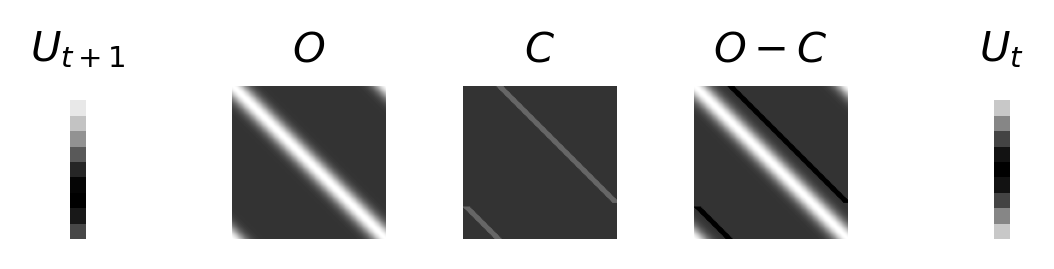

In [40]:
#get the connection matrix from the CANN, i.e., the generator
replay_cann = CANN1D(tau=1., tau_v=48., num=N, mbar=1.5)

weight_mat = np.zeros((N, N))
for i in range(N):
    weight_vec = replay_cann.make_conn_i(i)
    weight_mat[i,:] = weight_vec

offset = 30

fig = plt.figure(figsize=(4, 1), dpi=300)
labelsize = 10
ticksize = 8
#gridspec.GridSpec(2, 2)
gs = gridspec.GridSpec(1, 5)

#generate a M vector with Gaussian bump using numpy center at N/2
M=10
x = np.arange(M)
y = np.exp(-((x-M/1.5)**2)/(2*3**2))
y = y/np.sum(y)
y = 1-y
#plot the vector in the vertical way
ax0 = fig.add_subplot(gs[0, 0])
ax0.imshow(y[:, np.newaxis], cmap='gray', vmin=np.min(y), vmax=np.max(y))
ax0.set_yticks([]); ax0.set_xticks([])
ax0.set_title(r"$U_{t+1}$", fontsize=labelsize)

#plot the connection matrix
ax1 = fig.add_subplot(gs[0, 1])
minval = np.min(weight_mat)
maxval = np.max(weight_mat)
ax1.imshow(weight_mat, cmap='gray', vmin=minval-epsilon, vmax=maxval)
ax1.set_yticks([]); ax1.set_xticks([])
ax1.set_title(r"$O$", fontsize=labelsize)

#plot the pertubation matrix 1
ax2 = fig.add_subplot(gs[0, 2])
pertub_mat_1 = get_pertub_mat_4_visualization(N, epsilon, offset, width=3)
ax2.imshow(pertub_mat_1, cmap='gray', vmin=minval-epsilon, vmax=maxval)
ax2.set_yticks([]); ax2.set_xticks([])
ax2.set_title(r"$C$", fontsize=labelsize)

#subtract the pertubation matrix 1 from the connection matrix and plot
ax3 = fig.add_subplot(gs[0, 3])
ax3.imshow(weight_mat-pertub_mat_1, cmap='gray', vmin=minval-epsilon, vmax=maxval)
ax3.set_yticks([]); ax3.set_xticks([])
ax3.set_title(r"$O-C$", fontsize=labelsize)

#generate a M vector with Gaussian bump using numpy center at N/2
x = np.arange(M)
y = np.exp(-((x-M/2)**2)/(2*3**2))
y = y/np.sum(y)
y = 1-y
#plot the vector in the vertical way
ax4 = fig.add_subplot(gs[0, 4])
ax4.imshow(y[:, np.newaxis], cmap='gray', vmin=np.min(y), vmax=np.max(y))
ax4.set_yticks([]); ax0.set_xticks([])
ax4.set_title(r"$U_{t}$", fontsize=labelsize)

#set axis off
for ax in [ax0, ax1, ax2, ax3, ax4]:
    ax.axis('off')

plt.tight_layout()

#save the figure
plt.savefig('./Fig7_v2_pertubation_%d.pdf'%offset, dpi=300)

In [16]:
y

array([1.49110942, 1.4726151 , 1.43430704, 1.3772694 , 1.32142803,
       1.29765144, 1.32142803, 1.3772694 , 1.43430704, 1.4726151 ])